In [21]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import glob
import csv
import os
from PIL import Image
import config as cfg
from skimage import draw,measure,morphology
import sys
sys.path.append('/home/qiliu/Documents/Coding/DSB3/segment')
import tools
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [22]:
from skimage import transform
from imp import reload
reload(tools)
from skimage.morphology import binary_dilation,square,disk,binary_erosion
import tqdm

## Luna16 exploration

In [23]:
df_node = pd.read_csv(cfg.root+"annotations.csv")

In [40]:
#y = sitk.ReadImage(file_list[0])
dir(y)

['CopyInformation',
 'EraseMetaData',
 'GetDepth',
 'GetDimension',
 'GetDirection',
 'GetHeight',
 'GetITKBase',
 'GetMetaData',
 'GetMetaDataKeys',
 'GetNumberOfComponentsPerPixel',
 'GetOrigin',
 'GetPixel',
 'GetPixelAsComplexFloat64',
 'GetPixelID',
 'GetPixelIDTypeAsString',
 'GetPixelIDValue',
 'GetSize',
 'GetSpacing',
 'GetWidth',
 'HasMetaDataKey',
 'MakeUnique',
 'SetDirection',
 'SetMetaData',
 'SetOrigin',
 'SetPixel',
 'SetPixelAsComplexFloat64',
 'SetSpacing',
 'TransformContinuousIndexToPhysicalPoint',
 'TransformIndexToPhysicalPoint',
 'TransformPhysicalPointToContinuousIndex',
 'TransformPhysicalPointToIndex',
 '__GetPixelAsComplexFloat32__',
 '__GetPixelAsDouble__',
 '__GetPixelAsFloat__',
 '__GetPixelAsInt16__',
 '__GetPixelAsInt32__',
 '__GetPixelAsInt64__',
 '__GetPixelAsInt8__',
 '__GetPixelAsUInt16__',
 '__GetPixelAsUInt32__',
 '__GetPixelAsUInt64__',
 '__GetPixelAsUInt8__',
 '__GetPixelAsVectorFloat32__',
 '__GetPixelAsVectorFloat64__',
 '__GetPixelAsVectorInt1

In [33]:
luna_subset_path = os.path.join(cfg.root,"data","subset1")
file_list=glob.glob(os.path.join(luna_subset_path,"*.mhd"))

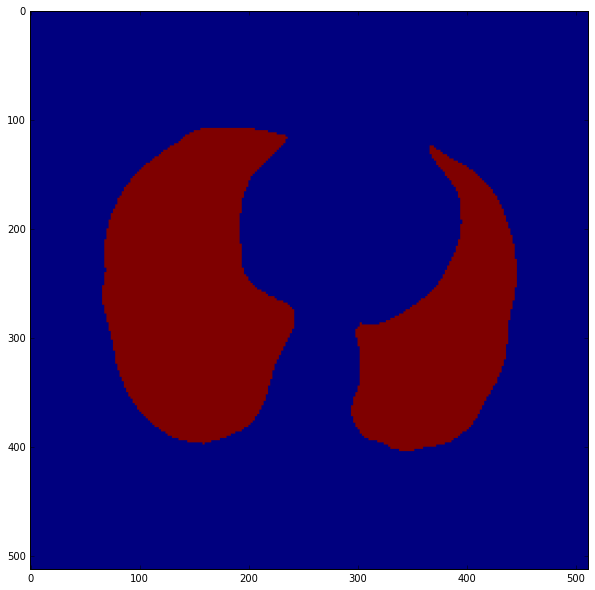

In [239]:
##quick test of segmentation
img_idx = 16;
numpyImage, numpyOrigin, numpySpacing = tools.load_itk_image(file_list[img_idx])
lungMask = tools.segment_lung_mask(numpyImage,speedup=2);
plt.imshow(lungMask[60,:,:])
#np.vstack(lungMask[1:3]).flatten()

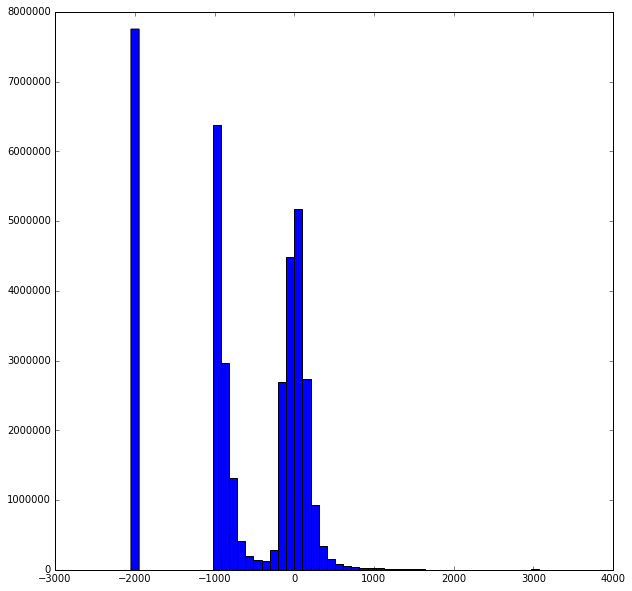

In [229]:
plt.hist(numpyImage.flatten(),bins=50);

In [236]:
img_idx = 27;
sid = file_list[img_idx].split('/')[-1][:-4]
sid_node = df_node[df_node.seriesuid==sid];
numpyImage, numpyOrigin, numpySpacing = tools.load_itk_image(file_list[img_idx])
sid_node

NameError: name 'file_list' is not defined

In [240]:
nodules = [];
for i in range(sid_node.shape[0]):
    xyz_world = np.array([sid_node.coordX.values[i],sid_node.coordY.values[i],sid_node.coordZ.values[i]]);
    xyz = tools.worldToVoxelCoord(xyz_world, numpyOrigin, numpySpacing);
    d_world = sid_node.diameter_mm.values[i];
    assert numpySpacing[0]==numpySpacing[1]
    d = d_world/numpySpacing[0];
    xyzd = tuple(np.append(xyz,d))
    print(xyzd)
    nodules.append(xyzd)
h = numpySpacing[2]/numpySpacing[0];

(400.0, 264.0, 91.0, 22.890790912)
(423.0, 239.0, 49.0, 30.830214215111113)


In [241]:
lungMask = tools.segment_lung_mask(numpyImage,speedup=4);

In [242]:
img,mask = tools.get_img_mask(numpyImage, h, nodules, nth=-1,z=91);

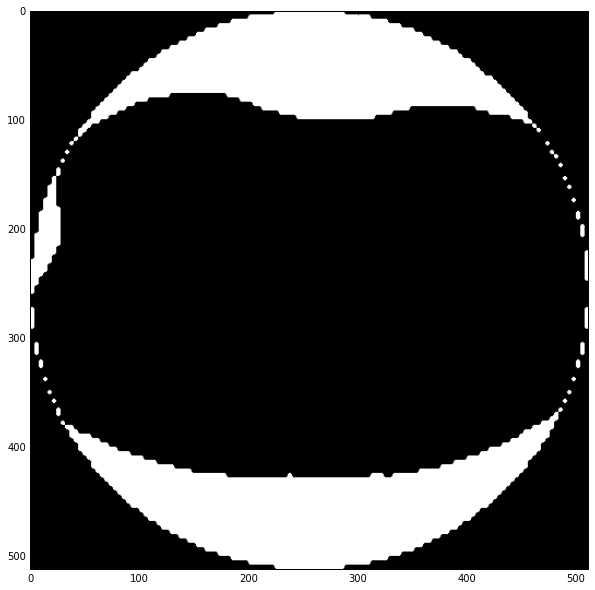

In [245]:
#tools.plot_img_with_mask(img*lungMask[91,:,:],mask)
#tools.plot_img_with_mask(img,mask)
#np.sum(lungMask[0:30,:,:])
#plt.hist(numpyImage[150,:,:].flatten(),bins=50);
#plt.imshow(numpyImage[162,:,:])
plt.imshow(lungMask[70,:,:],cmap='gray')

In [280]:
from skimage.segmentation import active_contour

In [421]:
#Method of contour finding does not work well. Simply use snake0, circle
xyzd = nodules[0];
N=10;
r = xyzd[3]/2.0+5;
snake0 =  np.array([[xyzd[1]+r*np.sin(2*np.pi*i/N),xyzd[0]+r*np.cos(2*np.pi*i/N)] \
                   for i in range(N)],dtype=np.float);
snake = active_contour(img, snake0, alpha=0.001, beta=0.1, w_edge=1, w_line=-1)

## Unet Model result test

In [131]:
import load_data as ld;
reload(ld)

<module 'load_data' from '/home/qiliu/Documents/Coding/DSB3/segment/load_data.py'>

In [132]:
full_train_data = ld.ImgStream("train", cfg.fitter['batch_size']);

labelled image : 3355
image data size  84598


In [149]:
# _,data = full_train_data.CV_fold_gen(0,5);
# it = iter(data);
x,y = next(it)

In [5]:
##test prediction
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""
from keras.models import load_model
import utils
def getmodel(tag, fold):
    model = load_model(os.path.join(cfg.params_dir, 'unet_{}_{}_fold{}.hdf5'.format(cfg.WIDTH, tag, fold)), custom_objects={'loss':utils.dice_coef_loss_gen(smooth=100)});
    return model;

Using TensorFlow backend.


In [165]:
model = getmodel(6,0);

In [166]:
xp = model.predict(x);
print(np.max(xp),np.sum(xp))

1.0 1052.13


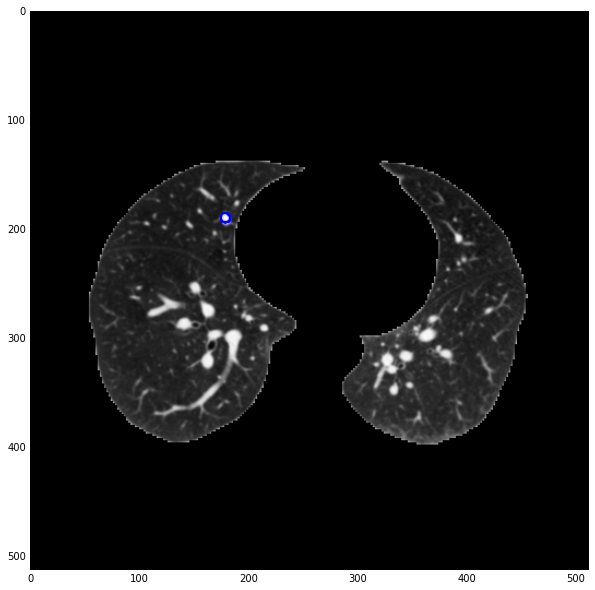

In [178]:
#plt.imshow(x[0,:,:,0],cmap='gray')
i=0
tools.plot_img_with_mask(x[i,:,:,0]+0.05,y[i,:,:,0],xp[i,:,:,0])

## DSB3 explore

In [25]:
dsb3_root = "/home/qiliu/Share/Clinical/lung/cancer/";
data_path = os.path.join(dsb3_root,"train","stage1")
ids = os.listdir(data_path);

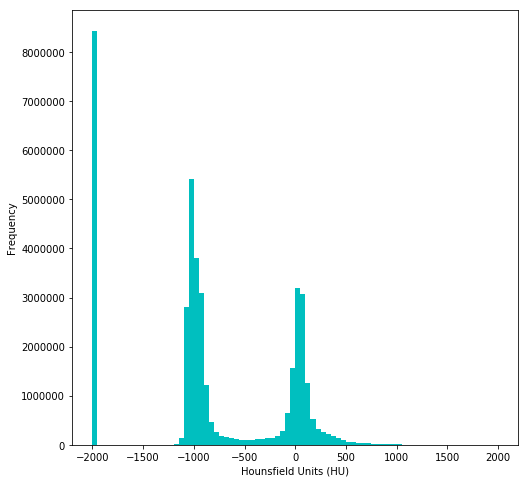

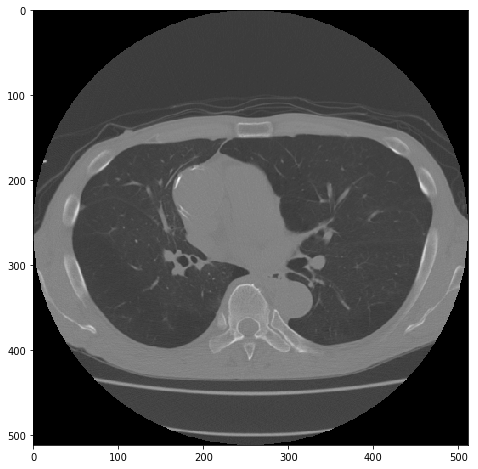

In [27]:
first_patient = tools.load_scan(os.path.join(data_path, ids[0]))
first_patient_pixels = tools.get_pixels_hu(first_patient)

plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

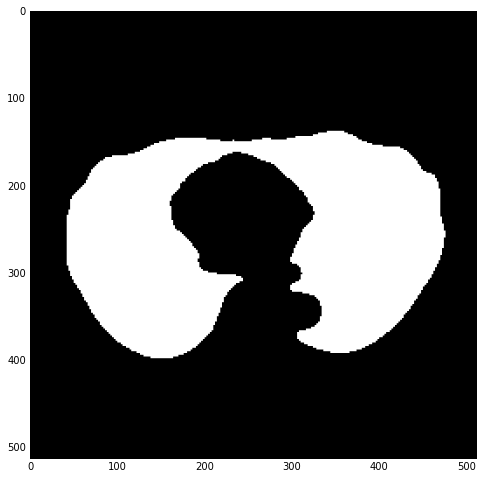

In [42]:
reload(tools)
lungMask = tools.segment_lung_mask(first_patient_pixels,speedup=2);
plt.imshow(lungMask[70,:,:],cmap='gray')
#plt.imshow((first_patient_pixels[80]<-320) & (first_patient_pixels[80]>-1400), cmap=plt.cm.gray)
# plt.show()
# plt.imshow(first_patient_pixels[160], cmap=plt.cm.gray)

In [45]:
## test segmentation
reload(tools)
for i in tqdm.tqdm(ids):
    patient = tools.load_scan(os.path.join(data_path, i))
    imgs = tools.get_pixels_hu(patient)
    lungMask = tools.segment_lung_mask(imgs,speedup=2);
    #plt.imshow(lungMask[lungMask.shape[0]//2,:,:])
    plt.imsave(os.path.join('/home/qiliu/Share/Clinical/lung/tmp/','{}.png'.format(i)), \
               lungMask[lungMask.shape[0]//2,:,:], cmap=plt.cm.binary);
    #break

# wrong = [];
# for i in range(8):
#     img = plt.imread(os.path.join('/home/qiliu/Share/Clinical/lung/tmp/','{}.png'.format(ids[i])));
#     wrong.append(np.mean(img));
# print(wrong)
# np.where(np.array(wrong)<0.90)

# img = plt.imread(os.path.join('/home/qiliu/Share/Clinical/lung/tmp/','{}.png'.format(ids[65])));
# plt.imshow(img)


100%|██████████| 1595/1595 [3:26:07<00:00,  6.82s/it]  


## Data Explore

In [114]:
data_path = '/home/qiliu/Share/Clinical/lung/NLST/100004/T0/'
files = os.listdir(data_path);
patient = tools.load_scan(os.path.join(data_path, files[1]))
patient_pixels = tools.get_pixels_hu(patient)

In [115]:
print(len(patient_pixels),patient_pixels[0].shape)

118 (512, 512)


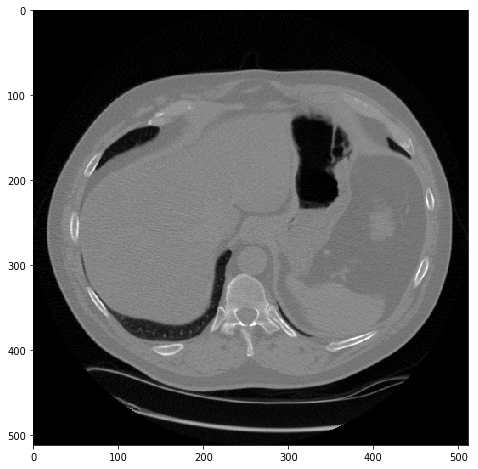

In [127]:
plt.imshow(patient_pixels[26], cmap=plt.cm.gray)
plt.show()

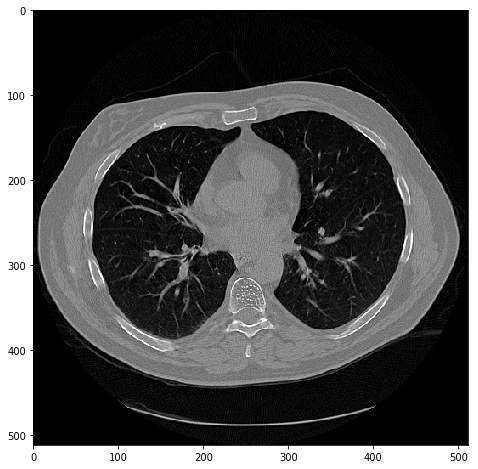

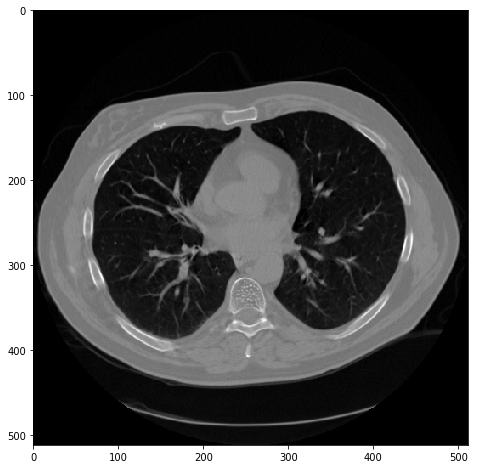

In [77]:
plt.imshow(x1, cmap=plt.cm.gray)
plt.show();
plt.imshow(x2, cmap=plt.cm.gray)

## nodule detect code test

In [226]:
model = getmodel(9,0);

In [227]:
dsb3_root = "/home/qiliu/Share/Clinical/lung/cancer/";
data_path = os.path.join(dsb3_root,"train","stage1")
ids = os.listdir(data_path);
dp = data_path;

s = tools.load_scan(os.path.join(dp,ids[4]));
imgs = tools.get_pixels_hu(s);
lungMask = tools.segment_lung_mask(imgs,speedup=2);
res = np.array(tools.normalize(imgs)*lungMask,np.float32)*(1.0/255)-0.05;
shape = tuple(list(res.shape)+[1]);
res = np.reshape(res,shape);
nodules = model.predict(res,batch_size=8);
shape = nodules.shape[:-1];
nodules = np.reshape(nodules,shape)*(lungMask>0.5);

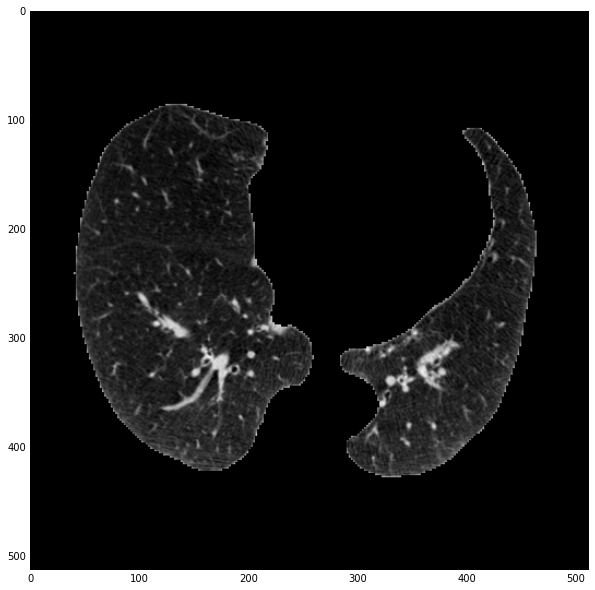

In [235]:
i=102
tools.plot_img_with_mask(res[i,:,:,0]+0.05,(nodules[i,:,:]>0.1))

In [93]:
#extract nodules
binary_nodule = np.array(nodules > 0.2, dtype=np.int8);
labels = measure.label(binary_nodule)

In [94]:
vals, counts = np.unique(labels, return_counts=True)
counts = counts[vals!=0]
vals = vals[vals!=0]
nl = sorted(zip(counts,vals),reverse=True);

In [109]:
xyz = np.where(labels==nl[0][1])
c = tuple(int(np.median(x)) for x in xyz)
s = tuple(int(np.max(x)-np.min(x))+1 for x in xyz)
print(c,s)

(90, 208, 66) (14, 32, 34)


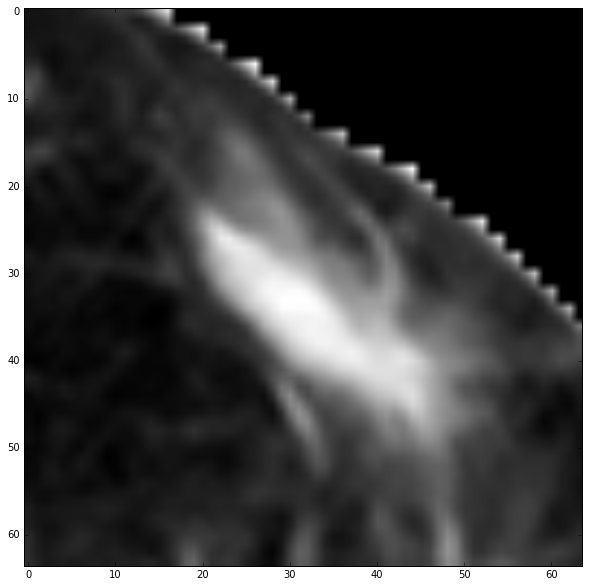

In [74]:
W=64;
plt.imshow(res[c[0],c[1]-W//2:c[1]+W//2,c[2]-W//2:c[2]+W//2,0]+0.05,cmap='gray')

In [11]:
#labels = pd.read_csv('/home/qiliu/Share/Clinical/lung/cancer/train/stage1_labels.csv');
labels.cancer.mean()

0.25912670007158195

In [246]:
import pickle
# res = [pickle.load(open('/home/qiliu/Share/Clinical/lung/cancer/nodule/stage1_3D_9/%s.pkl'%(labels.id[i]),'rb')) \
#        for i in range(labels.shape[0])];
res = pickle.load(open('/home/qiliu/Share/Clinical/lung/cancer/nodule/stage1_3D_6_10_sel/bbed0d350caad0e19e5b0fc858097ce4.pkl','rb'));

In [190]:
labels['count'] = [len(x[1]) for x in res]

In [191]:
print(np.sum((labels['count']>0) & (labels.cancer>0)))
print(np.sum((labels['count']>0) & (labels.cancer==0)))
print(np.sum((labels['count']==0) & (labels.cancer>0)))
print(np.sum((labels['count']==0) & (labels.cancer==0)))

289
575
73
460


In [194]:
p1=0.108;
print(p1,(1-p1)*np.log(1-p1)+p1*np.log(p1))

0.108 -0.342313316191


In [199]:
p2=0.34
print(p2,(1-p2)*np.log(1-p2)+p2*np.log(p2))

0.34 -0.641035477881


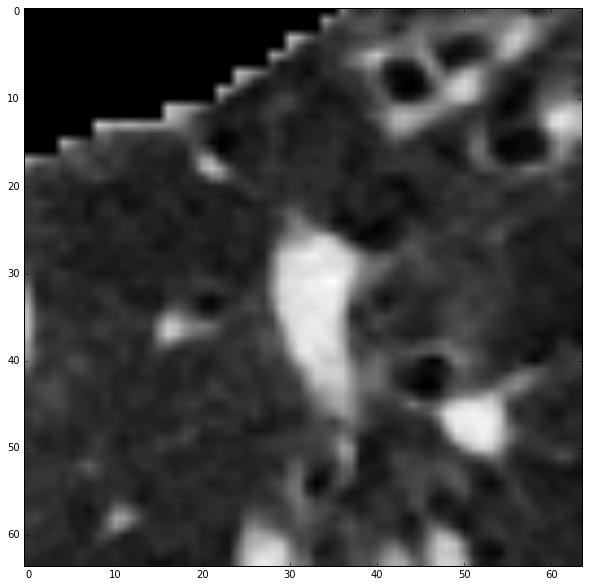

In [215]:
plt.imshow(res[0][1][:,:,8],cmap='gray')

In [220]:
tuple(list(res[0][0].shape)+[1])

(64, 64, 16, 1)

In [16]:
## average predictions
import pandas as pd
import os
d = '/home/qiliu/Share/Clinical/lung/cancer/nodule/results';
s = [pd.read_csv(os.path.join(d,'submit_tag{}.csv'.format(i))) for i in [16,17,18,19,20]];
# s1 = pd.read_csv(os.path.join(d,'submit_tag15.csv'));
# s2 = pd.read_csv(os.path.join(d,'submit_tag16.csv'));

In [18]:
#s1.cancer.values[:] = s1.cancer.values*0.4 + s2.cancer.values*0.6
#s0.cancer.values[:] = (s1.cancer.values*0.7 + s2.cancer.values*0.3)*0.5 + s0.cancer.values*0.5
import numpy as np
r = 0;
for x in s:
    r+=np.log(x.cancer.values/(1-x.cancer.values));
r/=len(s);

In [19]:
res = s[0].copy();
res.cancer=1.0/(1.0+np.exp(-r));

In [20]:
res.to_csv(os.path.join(d,'logave_16-20.csv'),index=False)

In [9]:
res.cancer.max()

0.85851752892090782

In [13]:
s1.cancer.mean()

0.26910156797299939

In [8]:
## shrink toward the mean.
0.259 * 0.2 + 0.8*x

10